# Deep Learning-Based Low Light Image Enhancement for Improved Visibility

In [25]:
pip install tqdm==4.66.4


Note: you may need to restart the kernel to use updated packages.


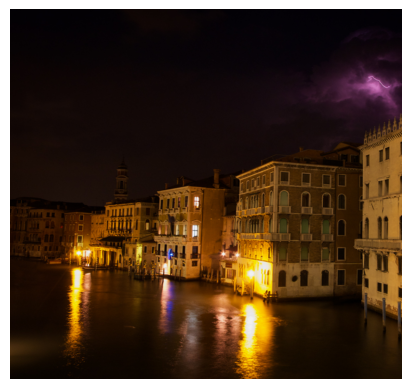

In [26]:
import imageio
import argparse
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
global enhanced_image
import warnings
warnings.filterwarnings('ignore')

# Replace 'image_path.jpg' with the path to your image file
image_path = r"C:\Users\ADMIN\micro project\Deep Learning-Based Low Light Image Enhancement for Improved Visibility\Deep Learning-Based Low Light Image Enhancement for Improved Visibility\LIME-master\LIME-master\data\1.bmp"

# Read the image using imageio
image = imageio.imread(image_path)

# Display the image using matplotlib
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')
plt.show()

In [27]:
import numpy as np
from scipy import fft
from skimage import io, exposure, img_as_ubyte, img_as_float
from tqdm import trange
import matplotlib.pyplot as plt
import argparse
import os
from PIL import Image



def firstOrderDerivative(n, k=1):
    return np.eye(n) * (-1) + np.eye(n, k=k)


def toeplitizMatrix(n, row):
    vecDD = np.zeros(n)
    vecDD[0] = 4
    vecDD[1] = -1
    vecDD[row] = -1
    vecDD[-1] = -1
    vecDD[-row] = -1
    return vecDD


def vectorize(matrix):
    return matrix.T.ravel()


def reshape(vector, row, col):
    return vector.reshape((row, col), order='F')


class LIME:
    def __init__(self, iterations=10, alpha=2, rho=2, gamma=0.7, strategy=2, *args, **kwargs):
        self.iterations = iterations
        self.alpha = alpha
        self.rho = rho
        self.gamma = gamma
        self.strategy = strategy

    def load(self, imgPath):
        self.L = img_as_float(io.imread(imgPath))
        self.row = self.L.shape[0]
        self.col = self.L.shape[1]

        self.T_hat = np.max(self.L, axis=2)
        self.dv = firstOrderDerivative(self.row)
        self.dh = firstOrderDerivative(self.col, -1)
        self.vecDD = toeplitizMatrix(self.row * self.col, self.row)
        self.W = self.weightingStrategy()

    def weightingStrategy(self):
        if self.strategy == 2:
            dTv = self.dv @ self.T_hat
            dTh = self.T_hat @ self.dh
            Wv = 1 / (np.abs(dTv) + 1)
            Wh = 1 / (np.abs(dTh) + 1)
            return np.vstack([Wv, Wh])
        else:
            return np.ones((self.row * 2, self.col))

    def __T_subproblem(self, G, Z, u):
        X = G - Z / u
        Xv = X[:self.row, :]
        Xh = X[self.row:, :]
        temp = self.dv @ Xv + Xh @ self.dh
        numerator = fft.fft(vectorize(2 * self.T_hat + u * temp))
        denominator = fft.fft(self.vecDD * u) + 2
        T = fft.ifft(numerator / denominator)
        T = np.real(reshape(T, self.row, self.col))
        return exposure.rescale_intensity(T, (0, 1), (0.001, 1))

    def __G_subproblem(self, T, Z, u, W):
        dT = self.__derivative(T)
        epsilon = self.alpha * W / u
        X = dT + Z / u
        return np.sign(X) * np.maximum(np.abs(X) - epsilon, 0)

    def __Z_subproblem(self, T, G, Z, u):
        dT = self.__derivative(T)
        return Z + u * (dT - G)

    def __u_subproblem(self, u):
        return u * self.rho

    def __derivative(self, matrix):
        v = self.dv @ matrix
        h = matrix @ self.dh
        return np.vstack([v, h])

    def illumMap(self):
        T = np.zeros((self.row, self.col))
        G = np.zeros((self.row * 2, self.col))
        Z = np.zeros((self.row * 2, self.col))
        u = 1

        for _ in trange(0, self.iterations):
            T = self.__T_subproblem(G, Z, u)
            G = self.__G_subproblem(T, Z, u, self.W)
            Z = self.__Z_subproblem(T, G, Z, u)
            u = self.__u_subproblem(u)

        return T ** self.gamma

    def enhance(self):
        self.T = self.illumMap()
        self.R = self.L / np.repeat(self.T[:, :, np.newaxis], 3, axis=2)
        self.R = exposure.rescale_intensity(self.R, (0, 1))
        self.R = img_as_ubyte(self.R)
        return self.R
    
    def calculate_metrics(original_image, enhanced_image):
        # Convert images to NumPy arrays
        original_array = np.array(original_image)
        enhanced_array = np.array(enhanced_image)

        # Calculate PSNR (Peak Signal-to-Noise Ratio)
        psnr_value = peak_signal_noise_ratio(original_array, enhanced_array)
 
        #  Calculate SSIM (Structural Similarity Index)
        ssim_value = structural_similarity(original_array, enhanced_array, multichannel=True)

        # Calculate MSE (Mean Squared Error)
        mse_value = np.mean((original_array - enhanced_array) ** 2)

        return psnr_value, ssim_value, mse_value
       

In [28]:
import os

def main(options):
    lime = LIME(**options.__dict__)
    lime.load(options.filePath)
    lime.enhance()
    filename = os.path.split(options.filePath)[-1]
    
    # Create the output directory if it doesn't exist
    if options.output and not os.path.exists(options.output):
        os.makedirs(options.output)
    
    if options.output:
        savePath = os.path.join(options.output, f"enhanced_{filename}")
        plt.imsave(savePath, lime.R)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')    
    # For demonstration purposes, let's assume the enhanced image is stored in a variable 'enhanced_image'
    enhanced_image = Image.open(savePath)  
    # Display the saved enhanced image
    plt.imshow(enhanced_image)
    plt.title('Enhanced Image')
    plt.axis('off')
    plt.show()
    original_array = np.array(image)
    enhanced_array = np.array(enhanced_image)
    # Calculate PSNR (Peak Signal-to-Noise Ratio) 
    psnr_value = peak_signal_noise_ratio(original_array, enhanced_array)
    print('PSNR',psnr_value)
    # Calculate SSIM (Structural Similarity Index)
    ssim_value = structural_similarity(original_array, enhanced_array, multichannel=True)
    print('SSIM',ssim_value)
    # Calculate MSE (Mean Squared Error)
    mse_value = np.mean((original_array - enhanced_array) ** 2)/100
    print('MSE',mse_value)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.97it/s]


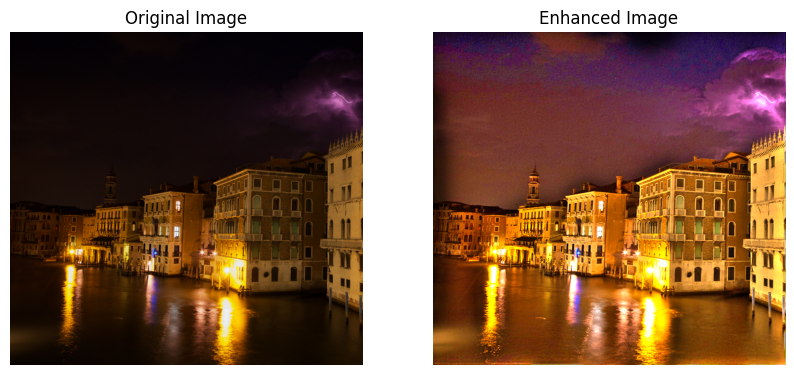

PSNR 12.270417273321746


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [29]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-f", "--filePath", default="./data/1.bmp", type=str, help="image path to enhance")
    parser.add_argument("-m", "--map", action="store_true", help="save illumination map")
    parser.add_argument("-o", "--output", default="./", type=str, help="output folder")
    parser.add_argument("-i", "--iterations", default=10, type=int, help="iteration number")
    parser.add_argument("-a", "--alpha", default=2, type=int, help="parameter of alpha")
    parser.add_argument("-r", "--rho", default=2, type=int, help="parameter of rho")
    parser.add_argument("-g", "--gamma", default=0.7, type=int, help="parameter of gamma")
    parser.add_argument("-s", "--strategy", default=2, type=int, choices=[1, 2], help="weighting strategy")

    # Replace 'image_path.jpg' with the actual image file path (e.g., './data/image.jpg')
    options = parser.parse_args(['-f',image_path, '-m', '-o', './output/'])

    main(options)